In [10]:
from torch import nn
from torch.utils.data import random_split, DataLoader
import torch
import torch.optim as optim
from datasets import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from torchvision.models import resnet101

from data.procesing import StreamingSongDataset

In [3]:
from data.procesing import ParseData

ParseData("raw_30s_cleantags_125artists", "E:/SongsDataset/raw_30s_melspecs/", "E:/SongsDataset/balanced-melspec-dataset/", features=96, chunks_per_batch=4096, chunk_size=256, per_label=325)

Reading: 55215 tracks, 11217 albums, 3552 artists
There are 50 genres in this partition.
There are 15 moods/themes in this partition.
There are 20 instruments in this partition.


  0%|          | 229/55215 [00:39<1:26:54, 10.55it/s] E:\Coding\SongAnalyzer\Analyzer\src\data\procesing.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
100%|██████████| 55215/55215 [25:20<00:00, 36.30it/s]  


In [16]:
from data.procesing import ReadStats

genre_count, genre_mapping = ReadStats("raw_30s_cleantags_125artists")

In [25]:
min(list(genre_count.values()))

325

In [17]:
all_songs_len = 325
ratios = [50 / 10] * 50 # TODO: Make actual calculated ratio

In [4]:
import os
import random
from data.procesing import StreamingSongDataset
from  torch.utils.data.dataset import random_split

directory = "balanced-melspec-dataset"
length = len(os.listdir(f"E:\\SongsDataset\\{directory}\\data"))

# Specify the train/test split ratio
train_ratio = 0.8
train_size = int(train_ratio * length)
test_size = length - train_size

random.seed(42)

full_dataset = StreamingSongDataset(f"E:\\SongsDataset\\{directory}\\data", f"E:\\SongsDataset\\{directory}\\genre_labels")
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

ValueError: Sum of input lengths does not equal the length of the input dataset!

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,  # Already shuffled
    num_workers=6,
    prefetch_factor=6,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,  # Already shuffled
    num_workers=6,
    prefetch_factor=6,
)

In [18]:
import torch

class Config:
    # === General ===
    model_name = "Resnet-Classifier-MEL"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32
    save_path = f"trained_models\\{model_name}\\"
    seed = 42

    # === Training ===
    num_epochs = 30
    batch_size = 24
    learning_rate = 1e-4
    weight_decay = 1e-4
    warmup_percent = 0.15
    max_grad_norm = 1.0
    log_every = 10  # steps between logs (optional)
    save_checkpoints = True

    # === Dataset ===
    use_masks = True
    num_workers = 4
    val_split = 0.2
    shuffle = True

    # === Model Behavior ===
    class_ratio = torch.tensor(ratios).to(device="cuda")

In [8]:
import torch.optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def train(model, test_dataloader, train_dataloader, config):
    # Training setup
    criterion = nn.BCEWithLogitsLoss(pos_weight=config.class_ratio)
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)  # L2 regularization
    model.to("cuda", config.dtype)

    # Training loop
    for epoch in range(40):
        train_loss_total = 0
        for batch in tqdm(train_dataloader):
            inputs, labels = batch

            inputs = inputs.squeeze(0).unsqueeze(1).to("cuda", config.dtype)
            labels = labels.squeeze(0).to("cuda", config.dtype)

            num_chunks = int(inputs.shape[0] / config.batch_size) + 1

            data_minibatches = torch.chunk(inputs, num_chunks, dim=0)
            label_minibatches = torch.chunk(labels, num_chunks, dim=0)

            for i, (data_minibatch, label_minibatch) in enumerate(zip(data_minibatches, label_minibatches)):
                outputs = model(data_minibatch)
                loss = criterion(outputs, label_minibatch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss_total += loss.item()

        # test_loss_average, all_preds, all_labels = eval(model, test_dataloader, criterion, config)
        #
        # precision_macro = precision_score(all_labels, all_preds, average='macro')
        # recall_macro = recall_score(all_labels, all_preds, average='macro')
        # f1_macro = f1_score(all_labels, all_preds, average='macro')

        train_loss_average = train_loss_total / len(train_dataloader)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss_average:.4f}")
        # print(f"Epoch {epoch + 1}, Test Loss: {test_loss_average:.4f}")
        #print(f"Test Accuracy: {correct / total:.2%}")
        # print(f"Precision: {precision_macro:.4f}\t Recall: {recall_macro:.4f}\t F1: {f1_macro:.4f}")

        torch.save(model, f".\\{config.save_path}\\Classifier-Epoch-{epoch + 1}.pt")


def eval(model, dataloader, criterion, config):
    test_loss_total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, labels = batch

            inputs = inputs.squeeze(0).unsqueeze(1).to("cuda", config.dtype)
            labels = labels.squeeze(0).to("cuda", config.dtype)

            num_chunks = int(inputs.shape[0] / config.batch_size) + 1

            data_minibatches = torch.chunk(inputs, num_chunks, dim=0)
            label_minibatches = torch.chunk(labels, num_chunks, dim=0)

            for i, (data_minibatch, label_minibatch) in enumerate(zip(data_minibatches, label_minibatches)):
                outputs = model(data_minibatch)
                loss = criterion(outputs, label_minibatch)

                test_loss_total += loss.item()

                all_preds.extend(outputs.sigmoid().cpu().numpy())
                all_labels.extend(label_minibatch.cpu().numpy())

    return test_loss_total / len(dataloader), all_preds, all_labels

def model_size(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [19]:
from models.ShortChunkCNN import ShortChunkCNN
import torch.nn as nn
from torch import optim
from tqdm import tqdm

model = ShortChunkCNN(n_channels=128, n_class=50)

print(f"Parameters: {model_size(model)}")
train(model, None, train_dataloader, Config)

Parameters: 3687346


100%|██████████| 1/1 [00:16<00:00, 16.42s/it]


Epoch 1, Train Loss: 77.2756


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Epoch 2, Train Loss: 38.4726


100%|██████████| 1/1 [00:08<00:00,  8.47s/it]


Epoch 3, Train Loss: 25.9341


100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


Epoch 4, Train Loss: 17.7452


100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Epoch 5, Train Loss: 12.6560


100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


Epoch 6, Train Loss: 8.9264


100%|██████████| 1/1 [00:08<00:00,  8.95s/it]


Epoch 7, Train Loss: 6.8370


100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Epoch 8, Train Loss: 5.1044


100%|██████████| 1/1 [00:09<00:00,  9.47s/it]


Epoch 9, Train Loss: 3.9948


100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Epoch 10, Train Loss: 3.1840


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Epoch 11, Train Loss: 2.5464


100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


Epoch 12, Train Loss: 2.1025


100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Epoch 13, Train Loss: 1.6214


100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Epoch 14, Train Loss: 1.4808


100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


Epoch 15, Train Loss: 1.2230


100%|██████████| 1/1 [00:08<00:00,  8.20s/it]


Epoch 16, Train Loss: 1.0170


  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [21]:
criterion = nn.BCEWithLogitsLoss(pos_weight=Config.class_ratio)
test_loss_average, all_probs, all_labels = eval(model, train_dataloader, criterion, Config)

all_p_tensor = torch.stack([torch.tensor(x) for x in all_probs], dim=0).float()
all_l_tensor = torch.stack([torch.tensor(x) for x in all_labels], dim=0).int()

100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


In [22]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def graph(probs, labels):
    # Store per-threshold values
    thresholds = np.linspace(0, 1, 200)
    precision_all = []
    recall_all = []

    for class_idx in range(probs.shape[1]):
        y_true = labels[:, class_idx]
        y_score = probs[:, class_idx]

        precision, recall, thresh = precision_recall_curve(y_true, y_score)

        # Interpolate to get precision/recall at uniform thresholds
        interp_precision = np.interp(thresholds, thresh, precision[:-1])  # precision[:-1] because it's len(thresh)+1
        interp_recall = np.interp(thresholds, thresh, recall[:-1])

        precision_all.append(interp_precision)
        recall_all.append(interp_recall)

    # Average across all classes
    precision_mean = np.mean(precision_all, axis=0)
    recall_mean = np.mean(recall_all, axis=0)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precision_mean, label='Precision')
    plt.plot(thresholds, recall_mean, label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold (Macro-Averaged over Genres)")
    plt.legend()
    plt.grid(True)
    plt.show()

E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Coding\SongAnalyzer\.venv\lib\site-packages\sklearn\metrics\_rankin

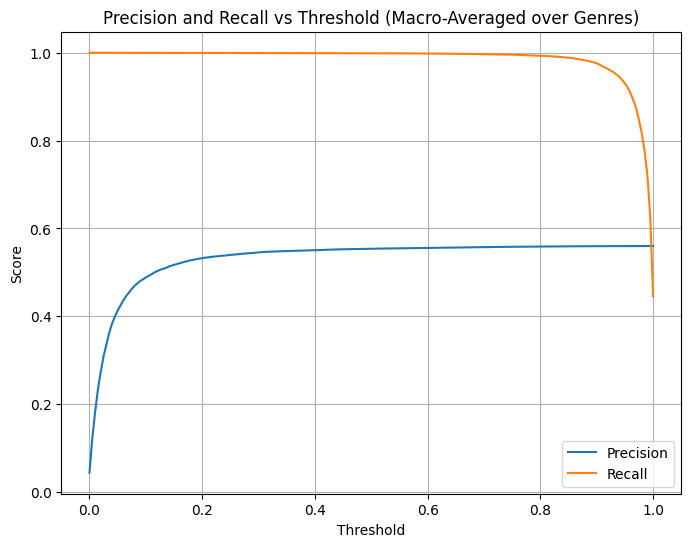

In [23]:
graph(all_p_tensor, all_l_tensor)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_p_tensor.ravel(), bins=100)
plt.title("Histogram of predicted genre probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
def toMEL(wv, sr):
    spec = librosa.feature.melspectrogram(y=wv, sr=sr)
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    return spec

def process_song(song_path, folder_in, folder_out, transform):
    latents_path_name = os.path.join(folder_out, song_path[:-4] + ".npy")

    if os.path.exists(latents_path_name):
        return

    try:
        wv, sr = librosa.load(os.path.join(folder_in, song_path), sr=44100)
        latent_space = transform(wv, sr)
        np.save(latents_path_name, latent_space)
    except Exception as e:
        print(f"Error processing {song_path}: {e}")

def encodeFolder(folder_in, folder_out, transform, num_threads=8):
    os.makedirs(folder_out, exist_ok=True)
    song_paths = os.listdir(folder_in)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(process_song, song_path, folder_in, folder_out, transform)
            for song_path in song_paths
        ]
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {folder_in}"):
            pass

# Run for folders 50 to 98
for index in range(0, 99):
    folder_name = f"E:/mtg-jamendo/{index:02}"
    encodeFolder(folder_name, "E:/SongsDataset/MELSPEC/", toMEL)

In [ ]:
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

In [ ]:
print(f"Precision: {precision_macro}\nRecall: {precision_macro}\nF1: {precision_macro}\n")